# Overview
In this notebook, we explore the use of **soft prompt tuning** as a parameter-efficient fine-tuning method for large language models (LLMs). Our goal is to compare the effectiveness of **soft prompts** against **hard prompts** in a text classification task.

- **Hard prompts** are manually designed natural language instructions (e.g., _"Classify the sentiment of this tweet as positive, neutral, or negative."_). These rely on human intuition and prompt engineering skills, but may not fully optimize model performance.  

- **Soft prompts**, on the other hand, are **learnable continuous embeddings** prepended to the model’s input. Instead of manually writing instructions, we optimize a small number of trainable virtual tokens that guide the LLM to perform the downstream task. This allows us to adapt powerful LLMs with far fewer trainable parameters compared to full fine-tuning.

We use **Meta’s LLaMA 3.2 (1B)** model for experimentation since it is lightweight enough for demonstration while still retaining strong generalization ability.  

---

### Step 1: Environment Setup
In the cell below, we install the necessary libraries and verify that a GPU is available for training. GPU acceleration is important for handling LLaMA models efficiently. We also suppress warnings and configure logging for cleaner outputs.

In [1]:
# Install required packages
!pip install -q transformers datasets accelerate peft bitsandbytes scipy scikit-learn torch torchvision torchaudio --upgrade
!pip install -q sentencepiece protobuf

import os
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')
from transformers.utils import logging

logging.set_verbosity_error()

# Check GPU availability
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 135.9 MB/s eta 0:00:00
GPU Available: True
GPU Device: NVIDIA A100-SXM4-40GB
GPU Memory: 42.47 GB


In [2]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import (
    PromptTuningConfig,
    PromptTuningInit,
    get_peft_model,
    TaskType,
    PeftModel
)
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.auto import tqdm
import json
import time
from torch.utils.data import DataLoader

### Step 2: Dataset Preparation — TweetEval (Sentiment Analysis)

To demonstrate the difference between **hard prompts** and **soft prompt tuning**, we need a standard text classification task. For this experiment, we use the **TweetEval** benchmark, specifically the **sentiment analysis task**.  

- **Dataset**: `tweet_eval` (sentiment)  
- **Classes**:  
  - `0` → Negative sentiment  
  - `1` → Neutral sentiment  
  - `2` → Positive sentiment  

This dataset contains short, noisy, real-world tweets, making it an excellent benchmark for prompt-based methods since tweets often lack context and require the model to infer tone from subtle cues.  

We will load the dataset, inspect its structure, and print out sample tweets to better understand what the model will be trained (or prompted) on.  


In [3]:
# Load tweet_eval dataset (sentiment task)
dataset = load_dataset("tweet_eval", "sentiment")

print("Dataset structure:")
print(dataset)
print("\nLabel mappings: 0=negative, 1=neutral, 2=positive")
print(f"Train samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

# Sample data
print("\nSample tweets:")
for i in range(3):
    print(f"Tweet: {dataset['train']['text'][i]}")
    print(f"Label: {dataset['train']['label'][i]}\n")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Label mappings: 0=negative, 1=neutral, 2=positive
Train samples: 45615
Validation samples: 2000
Test samples: 12284

Sample tweets:
Tweet: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
Label: 2

Tweet: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
Label: 1

Tweet: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
Label: 1



### Step 3: Model Setup — LLaMA 3.2 (1B)

We use **Meta’s LLaMA 3.2 (1B)** model as the backbone for our experiments.  
This model is large enough to capture rich language representations but still small enough to run on a single GPU with quantization.  

#### Why LLaMA 3.2 (1B)?
- Provides strong language understanding for classification tasks.  
- Efficient size compared to larger LLaMA variants, making it more practical for demonstrations.  
- Compatible with parameter-efficient fine-tuning methods such as **soft prompts**.  

#### Quantization with `bitsandbytes`
To make the model more memory-efficient, we apply **4-bit quantization** via the `bitsandbytes` library. This reduces GPU memory usage while preserving most of the model’s performance.  

- `load_in_4bit=True`: Loads model weights in 4-bit precision.  
- `nf4`: A specialized quantization scheme optimized for LLMs.  
- `torch.float16` compute dtype: Ensures fast mixed-precision computation.  
- Double quantization: Further reduces memory footprint.  

#### Tokenizer Configuration
- Loads the tokenizer associated with LLaMA 3.2.  
- Ensures proper handling of sequence padding by setting the padding token to the end-of-sequence (`eos_token`) if it is not already defined.  

Finally, we load the model with quantization and print out its memory footprint. This helps us verify that the setup is efficient and GPU-friendly before training or inference.  


In [4]:
model_name = "meta-llama/Llama-3.2-1B"

# Configure quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    padding_side='left'
)

# Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Load model with quantization
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

print(f"Model loaded: {model_name}")
print(f"Model size: {base_model.get_memory_footprint() / 1e9:.2f} GB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Model loaded: meta-llama/Llama-3.2-1B
Model size: 1.01 GB


### Step 4: Data Preprocessing for Hard and Soft Prompts

Before running experiments, we need to prepare the dataset for both **hard prompting** and **soft prompt tuning** approaches.  
The preprocessing differs slightly depending on which method we use:

#### Hard Prompt Preprocessing
- We manually insert the tweet into a **fixed natural language template**.  
- Example template:  

Classify the sentiment of this tweet as positive, neutral, or negative.
Tweet: {tweet}
Sentiment:
- The expected target is the sentiment label (`negative`, `neutral`, or `positive`).  
- This mimics how a user might design prompts by hand when using an LLM in zero-shot or few-shot settings.

#### Soft Prompt Preprocessing
- We do not rely on a manually written template.  
- Instead, we format the input minimally (e.g., `Tweet: {text}\nSentiment:`).  
- The **learnable soft prompt embeddings** will be prepended automatically during training, guiding the model toward the task.  
- The expected target remains the same (`negative`, `neutral`, or `positive`).  

#### Tokenization
We then tokenize both the **inputs** and **targets** so that they can be processed by the LLaMA model:
- Inputs are padded/truncated to a maximum length (`128` tokens).  
- Targets (labels) are tokenized separately, with a smaller maximum length (`10` tokens), since labels are short text strings.  
- Labels are stored in the same structure as inputs for model training.  

This preprocessing ensures that our dataset is ready for **both hard prompt evaluation** and **soft prompt fine-tuning** in the next steps.  


In [5]:
def preprocess_for_hard_prompt(examples, prompt_template):
    """Preprocess data for hard prompting"""
    label_map = {0: "negative", 1: "neutral", 2: "positive"}

    inputs = []
    targets = []

    for text, label in zip(examples['text'], examples['label']):
        # Create input with hard prompt
        input_text = prompt_template.format(tweet=text)
        target_text = label_map[label]

        inputs.append(input_text)
        targets.append(target_text)

    return inputs, targets

def preprocess_for_soft_prompt(examples):
    """Preprocess data for soft prompt tuning"""
    label_map = {0: "negative", 1: "neutral", 2: "positive"}

    inputs = []
    targets = []

    for text, label in zip(examples['text'], examples['label']):
        # For soft prompts, we just need the tweet and label
        # The soft prompt tokens will be prepended automatically
        input_text = f"Tweet: {text}\nSentiment:"
        target_text = label_map[label]

        inputs.append(input_text)
        targets.append(target_text)

    return inputs, targets

def tokenize_function(examples, tokenizer, max_length=128):
    """Tokenize inputs and targets"""
    inputs = examples['input']
    targets = examples['target']

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Tokenize targets for labels
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=10,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

### Step 5: Hard Prompt Baseline Evaluation

We begin our experiments by testing **hard prompts**.  
This provides a baseline for comparison with soft prompt tuning.

#### Hard Prompt Templates
We define several natural language templates that guide the model to classify tweet sentiment.

These prompts are designed to be **simple but varied**, since different phrasings can affect model performance.  

#### Evaluation Procedure
- We randomly sample **500 tweets** from the test set (for efficiency).  
- Each tweet is inserted into the chosen prompt template.  
- The model generates a short continuation (up to 5 tokens) predicting the sentiment.  
- We parse the output and map it back to the sentiment labels (`negative`, `neutral`, `positive`).  
- If parsing fails, we default to `neutral` to avoid errors.  
- Finally, we compute **Accuracy** and **Weighted F1 Score** to measure classification quality.  

#### Purpose
This step answers the question:  
**"How well does a pretrained LLaMA model perform with only handcrafted prompts, without any additional training?"**  

The results from these hard prompts will serve as a **baseline** against which we can compare the improvements gained from **soft prompt tuning**.  




In [6]:
# Define hard prompt templates
hard_prompt_templates = [
    "Classify the sentiment of this tweet as positive, neutral, or negative.\nTweet: {tweet}\nSentiment:",
    "Tweet sentiment analysis:\nText: {tweet}\nThe sentiment is:",
    "Analyze the following tweet and determine if it's positive, neutral, or negative:\n{tweet}\nAnswer:",
]

def evaluate_hard_prompt(model, tokenizer, dataset, prompt_template, sample_size=500):
    """Evaluate hard prompting performance"""
    model.eval()

    predictions = []
    true_labels = []
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    reverse_label_map = {v: k for k, v in label_map.items()}

    # Sample subset for faster evaluation
    indices = np.random.choice(len(dataset), min(sample_size, len(dataset)), replace=False)

    with torch.no_grad():
        for idx in tqdm(indices, desc="Evaluating hard prompt"):
            text = dataset['text'][int(idx)]
            label = dataset['label'][int(idx)]

            # Create prompt
            prompt = prompt_template.format(tweet=text)

            # Tokenize
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256)
            inputs = {k: v.cuda() for k, v in inputs.items()}

            # Generate
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )

            # Decode
            generated = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

            # Parse prediction
            pred_label = generated.strip().lower().split()[0] if generated.strip() else "neutral"
            if pred_label not in reverse_label_map:
                pred_label = "neutral"  # Default to neutral if can't parse

            predictions.append(reverse_label_map[pred_label])
            true_labels.append(label)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Evaluate different hard prompts
print("Evaluating hard prompting baselines...")
hard_prompt_results = {}

for i, template in enumerate(hard_prompt_templates):
    print(f"\nEvaluating prompt template {i+1}...")
    results = evaluate_hard_prompt(
        base_model,
        tokenizer,
        dataset['test'],
        template,
        sample_size=500
    )
    hard_prompt_results[f'template_{i+1}'] = results
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")

# Select best hard prompt
best_hard_prompt = max(hard_prompt_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest hard prompt: {best_hard_prompt[0]}")
print(f"Best accuracy: {best_hard_prompt[1]['accuracy']:.4f}")

Evaluating hard prompting baselines...

Evaluating prompt template 1...


Evaluating hard prompt:   0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 0.4800
F1 Score: 0.3322

Evaluating prompt template 2...


Evaluating hard prompt:   0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 0.4720
F1 Score: 0.3917

Evaluating prompt template 3...


Evaluating hard prompt:   0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 0.4440
F1 Score: 0.4039

Best hard prompt: template_1
Best accuracy: 0.4800


### Step 6: Preparing Data for Soft Prompt Tuning

Now that we have established a hard prompt baseline, we move on to **soft prompt tuning**.  
Unlike hard prompts, where we rely on carefully crafted instructions, soft prompts learn **continuous prompt embeddings** that guide the model during training.

#### Dataset Preparation
To train soft prompts, we need to slightly restructure the dataset:

1. **Input construction**  
   - For each tweet, we format the input as:  
     ```
     Tweet: {text}
     Sentiment:
     ```
   - Unlike hard prompts, the "prompt" portion will be learned through trainable embeddings rather than fixed words.

2. **Target construction**  
   - The target remains the sentiment label (`negative`, `neutral`, or `positive`).  

3. **Input + Target Combination**  
   - During training, we concatenate input and target (e.g., `"Tweet: The movie was great! Sentiment: positive"`).  
   - This lets the model learn to predict the correct label given the input tweet.  

4. **Tokenization**  
   - We tokenize the combined input+target into model-ready tensors.  
   - Labels are set equal to the input IDs so that training uses **causal language modeling** (predicting the target continuation).  
   - Inputs are padded and truncated to a maximum sequence length (`150 tokens`).  

#### Efficiency Considerations
- We **limit the dataset size** to a subset of 3,000 training samples and 500 validation samples.  
- This keeps training lightweight and feasible for demonstration purposes while still being large enough to show meaningful improvements.  

By preparing the dataset this way, we set up the model for **parameter-efficient soft prompt training**, where only the prompt embeddings will be updated while the rest of the model remains frozen.  


In [7]:
# Prepare datasets for soft prompt tuning
def prepare_soft_prompt_dataset(dataset_split, tokenizer, max_samples=5000):
    """Prepare dataset for soft prompt training"""
    # Limit samples for faster training
    n_samples = min(len(dataset_split), max_samples)
    subset = dataset_split.select(range(n_samples))

    inputs, targets = preprocess_for_soft_prompt(subset)

    # Create dataset dict
    data_dict = {
        'input': inputs,
        'target': targets,
        'label': subset['label']
    }

    # Convert to Dataset
    formatted_dataset = Dataset.from_dict(data_dict)

    # Tokenize
    def tokenize_batch(examples):
        # Combine input and target for training
        full_texts = [f"{inp} {tgt}" for inp, tgt in zip(examples['input'], examples['target'])]

        tokenized = tokenizer(
            full_texts,
            truncation=True,
            padding='max_length',
            max_length=150,
            return_tensors='pt'
        )

        tokenized['labels'] = tokenized['input_ids'].clone()
        return tokenized

    tokenized_dataset = formatted_dataset.map(
        tokenize_batch,
        batched=True,
        remove_columns=['input', 'target', 'label']
    )

    return tokenized_dataset

# Prepare train and validation datasets
train_dataset = prepare_soft_prompt_dataset(dataset['train'], tokenizer, max_samples=3000)
val_dataset = prepare_soft_prompt_dataset(dataset['validation'], tokenizer, max_samples=500)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Training samples: 3000
Validation samples: 500


### Step 7: Soft Prompt Tuning with PEFT

With the dataset prepared, we now set up **soft prompt tuning** using the [PEFT (Parameter-Efficient Fine-Tuning)](https://huggingface.co/docs/peft/index) library.  
This approach allows us to adapt LLaMA 3.2 (1B) to the sentiment classification task by training only a small set of **virtual prompt tokens**, while keeping the rest of the model frozen.

#### Configuration
- **Number of Virtual Tokens**: `20` soft tokens are prepended to each input sequence.  
- **Initialization**: The soft prompts are initialized from a short text string:  "Classify the sentiment of the following tweet as positive, neutral, or negative:" This gives the embeddings a meaningful starting point.  
- **Task Type**: `CAUSAL_LM` (causal language modeling), since we’re training the model to generate the correct sentiment label.  

#### Training Setup
- **Optimizer Settings**:  
- Higher learning rate (`3e-2`) compared to standard fine-tuning, since we are only training a small set of parameters.  
- **Batching & Accumulation**:  
- Batch size = 8, with gradient accumulation for stability.  
- **Epochs**: 10 passes over the dataset for convergence.  
- **Precision**: FP16 training for efficiency on GPU.  
- **Evaluation**: Evaluated at the end of each epoch, selecting the model with the lowest validation loss.  
- **Data Collator**: Uses `DataCollatorForLanguageModeling` (causal LM objective).  

#### Training Efficiency
Since we only train the **soft prompt embeddings** (not the full model), the number of trainable parameters is tiny compared to LLaMA’s billions of frozen parameters.  
This drastically reduces GPU memory usage and training time, while still enabling task adaptation.  

At the end of training:
- We report the total training time.  
- Save the final soft prompt–tuned model for evaluation.  

This sets the stage for the **comparison phase**, where we evaluate whether learned soft prompts outperform handcrafted hard prompts.  


In [8]:
# Configure soft prompt tuning
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=20,  # Number of soft prompt tokens
    prompt_tuning_init_text="Classify the sentiment of the following tweet as positive, neutral, or negative:",
    tokenizer_name_or_path=model_name,
)

# Create PEFT model
print("Creating PEFT model with soft prompts...")
peft_model = get_peft_model(base_model, peft_config)
print(f"Trainable parameters: {peft_model.print_trainable_parameters()}")

# Training arguments
training_args = TrainingArguments(
    output_dir="./soft_prompt_model",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    learning_rate=3e-2,  # Higher LR for soft prompts
    fp16=True,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="none",
    remove_unused_columns=False,
)

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

# Create trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

# Train soft prompts
print("\nTraining soft prompts...")
training_start = time.time()
trainer.train()
training_time = time.time() - training_start
print(f"Training completed in {training_time:.2f} seconds")

# Save the model
peft_model.save_pretrained("./soft_prompt_final")

Creating PEFT model with soft prompts...
trainable params: 40,960 || all params: 1,235,855,360 || trainable%: 0.0033
Trainable parameters: None

Training soft prompts...
{'eval_loss': 3.285116195678711, 'eval_runtime': 3.9581, 'eval_samples_per_second': 126.323, 'eval_steps_per_second': 15.917, 'epoch': 1.0}
{'eval_loss': 3.101804256439209, 'eval_runtime': 3.9926, 'eval_samples_per_second': 125.231, 'eval_steps_per_second': 15.779, 'epoch': 2.0}
{'eval_loss': 3.070282220840454, 'eval_runtime': 3.9471, 'eval_samples_per_second': 126.675, 'eval_steps_per_second': 15.961, 'epoch': 3.0}
{'eval_loss': 3.0554819107055664, 'eval_runtime': 3.9303, 'eval_samples_per_second': 127.217, 'eval_steps_per_second': 16.029, 'epoch': 4.0}
{'eval_loss': 3.043901205062866, 'eval_runtime': 3.9058, 'eval_samples_per_second': 128.015, 'eval_steps_per_second': 16.13, 'epoch': 5.0}
{'loss': 3.1421, 'grad_norm': 0.1081133559346199, 'learning_rate': 0.01575, 'epoch': 5.32}
{'eval_loss': 3.0372440814971924, 'eval

### Step 8: Evaluating the Soft Prompt Model

With training complete, we now evaluate the **soft prompt–tuned model** on the test set to see how well it generalizes compared to the hard prompt baselines.

#### Evaluation Procedure
- Randomly sample **500 tweets** from the test set (to keep evaluation efficient).  
- The learned soft prompts are automatically prepended by the model.  
- The model generates a short continuation (up to 5 tokens), which should correspond to the sentiment label (`negative`, `neutral`, `positive`).  
- We parse the generated output, mapping it back to one of the three sentiment classes.  
- If parsing fails, we default to `"neutral"` to ensure robustness.  
- We then compute:
- **Accuracy** → Proportion of correct predictions.  
- **Weighted F1 Score** → Accounts for class imbalance by weighting performance across sentiment classes.  

#### Purpose
This step answers the central question of our experiment:  
**"Can trainable soft prompts outperform manually crafted hard prompts for text classification?"**  

By comparing the results here with the hard prompt baseline, we can quantify the effectiveness of **parameter-efficient fine-tuning** versus traditional prompt engineering.  



In [9]:
def evaluate_soft_prompt(model, tokenizer, dataset, sample_size=500):
    """Evaluate soft prompt model performance"""
    model.eval()

    predictions = []
    true_labels = []
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    reverse_label_map = {v: k for k, v in label_map.items()}

    # Sample subset
    indices = np.random.choice(len(dataset), min(sample_size, len(dataset)), replace=False)

    with torch.no_grad():
        for idx in tqdm(indices, desc="Evaluating soft prompt"):
            text = dataset['text'][int(idx)]
            label = dataset['label'][int(idx)]

            # Format input for soft prompt
            input_text = f"Tweet: {text}\nSentiment:"

            # Tokenize
            inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=128)
            inputs = {k: v.cuda() for k, v in inputs.items()}

            # Generate
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )

            # Decode
            generated = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

            # Parse prediction
            pred_label = generated.strip().lower().split()[0] if generated.strip() else "neutral"
            if pred_label not in reverse_label_map:
                pred_label = "neutral"

            predictions.append(reverse_label_map[pred_label])
            true_labels.append(label)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Evaluate soft prompt model
print("Evaluating soft prompt model...")
soft_prompt_results = evaluate_soft_prompt(
    peft_model,
    tokenizer,
    dataset['test'],
    sample_size=500
)

print(f"\nSoft Prompt Results:")
print(f"Accuracy: {soft_prompt_results['accuracy']:.4f}")
print(f"F1 Score: {soft_prompt_results['f1_score']:.4f}")

Evaluating soft prompt model...


Evaluating soft prompt:   0%|          | 0/500 [00:00<?, ?it/s]


Soft Prompt Results:
Accuracy: 0.5720
F1 Score: 0.5344


### Step 9: Results Visualization & Final Summary

Now that both **hard prompting baselines** and the **soft prompt–tuned model** have been evaluated, we generate visualizations and summary statistics to clearly compare performance.

#### Visualizations
1. **Bar Chart (top-left):**  
   Compares accuracy and weighted F1 score across all methods (three hard prompts + soft prompt).  

2. **Confusion Matrix (top-right):**  
   Shows how well the soft prompt model distinguishes between *Negative*, *Neutral*, and *Positive* tweets. This reveals which classes the model struggles with most.  

3. **Accuracy Improvement Plot (bottom-left):**  
   Highlights the performance gap between the best hard prompt and the soft prompt–tuned model, with the relative improvement percentage annotated.  

4. **Classification Report Table (bottom-right):**  
   Displays precision, recall, and F1 for each class individually, plus the overall weighted F1.  

#### Printed Summary
After the plots, we print:
- **Best Hard Prompt Performance** (accuracy + F1).  
- **Soft Prompt Performance**.  
- **Relative Improvement** in both metrics.  
- **Training Efficiency** (time taken, trainable parameter count, total parameter count).  

This provides a complete picture:  
- How much better soft prompting is than manual prompt engineering.  
- Which sentiment classes see the biggest gains.  
- The **efficiency trade-off**, showing that we only needed to train a **tiny fraction of parameters** while still improving accuracy.  


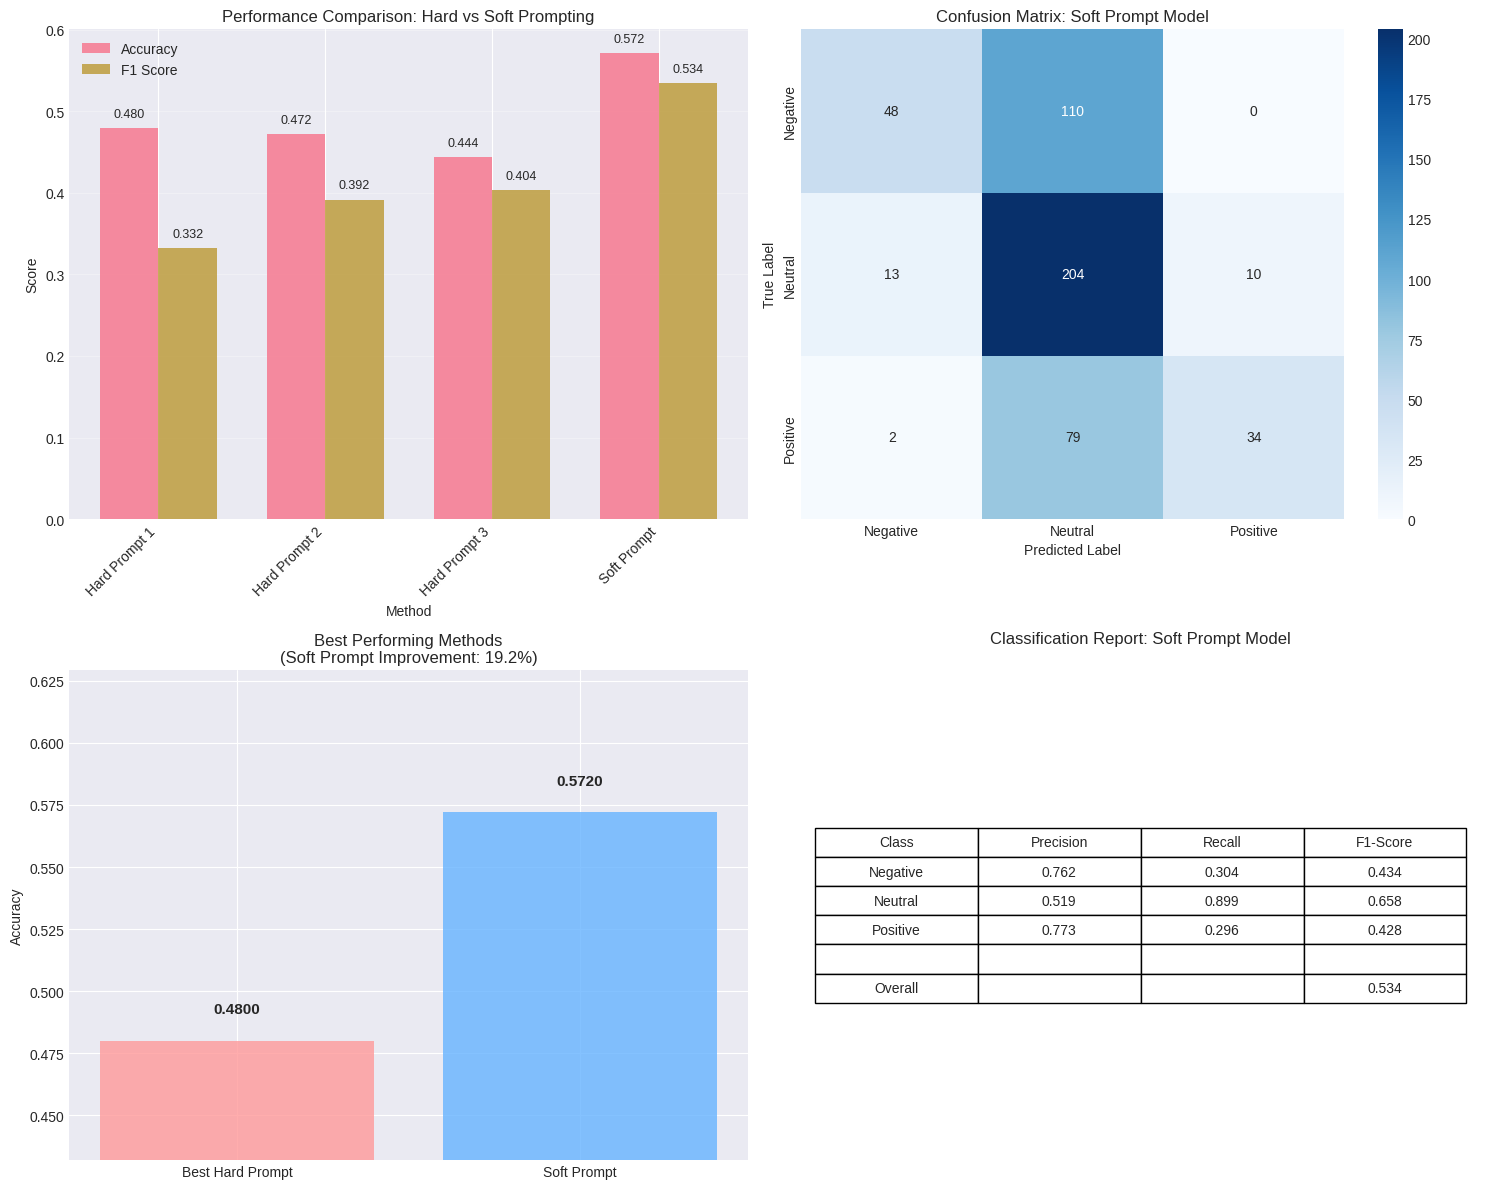


FINAL RESULTS SUMMARY

Best Hard Prompt Performance:
  - Template: template_1
  - Accuracy: 0.4800
  - F1 Score: 0.3322

Soft Prompt Performance:
  - Accuracy: 0.5720
  - F1 Score: 0.5344

Improvement over best hard prompt:
  - Accuracy: 19.17%
  - F1 Score: 60.87%

Training Efficiency:
  - Training time: 482.65 seconds
  - Trainable parameters: ~0.0K
  - Total parameters: ~1.24B


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create comparison dataframe
comparison_data = {
    'Method': [],
    'Accuracy': [],
    'F1 Score': []
}

# Add hard prompting results
for template_name, results in hard_prompt_results.items():
    comparison_data['Method'].append(f'Hard Prompt {template_name[-1]}')
    comparison_data['Accuracy'].append(results['accuracy'])
    comparison_data['F1 Score'].append(results['f1_score'])

# Add soft prompt results
comparison_data['Method'].append('Soft Prompt')
comparison_data['Accuracy'].append(soft_prompt_results['accuracy'])
comparison_data['F1 Score'].append(soft_prompt_results['f1_score'])

comparison_df = pd.DataFrame(comparison_data)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Bar plot comparison
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
bars2 = ax1.bar(x + width/2, comparison_df['F1 Score'], width, label='F1 Score', alpha=0.8)

ax1.set_xlabel('Method')
ax1.set_ylabel('Score')
ax1.set_title('Performance Comparison: Hard vs Soft Prompting')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Method'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Confusion Matrix for Soft Prompt
ax2 = axes[0, 1]
cm = confusion_matrix(soft_prompt_results['true_labels'], soft_prompt_results['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
ax2.set_title('Confusion Matrix: Soft Prompt Model')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. Performance improvement analysis
ax3 = axes[1, 0]
best_hard_acc = best_hard_prompt[1]['accuracy']
soft_acc = soft_prompt_results['accuracy']
improvement = ((soft_acc - best_hard_acc) / best_hard_acc) * 100

categories = ['Best Hard Prompt', 'Soft Prompt']
values = [best_hard_acc, soft_acc]
colors = ['#ff9999', '#66b3ff']

bars = ax3.bar(categories, values, color=colors, alpha=0.8)
ax3.set_ylabel('Accuracy')
ax3.set_title(f'Best Performing Methods\n(Soft Prompt Improvement: {improvement:.1f}%)')
ax3.set_ylim([min(values) * 0.9, max(values) * 1.1])

for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2., val + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Classification report
ax4 = axes[1, 1]
ax4.axis('off')

# Generate classification report
report = classification_report(
    soft_prompt_results['true_labels'],
    soft_prompt_results['predictions'],
    target_names=['Negative', 'Neutral', 'Positive'],
    output_dict=True
)

# Format report as table
report_data = []
for label in ['Negative', 'Neutral', 'Positive']:
    if label.lower() in report:
        metrics = report[label.lower()]
    else:
        metrics = report[label] if label in report else {'precision': 0, 'recall': 0, 'f1-score': 0}
    report_data.append([
        label,
        f"{metrics['precision']:.3f}",
        f"{metrics['recall']:.3f}",
        f"{metrics['f1-score']:.3f}"
    ])

# Add overall metrics
report_data.append(['', '', '', ''])
report_data.append(['Overall', '', '', f"{report['weighted avg']['f1-score']:.3f}"])

table = ax4.table(cellText=report_data,
                  colLabels=['Class', 'Precision', 'Recall', 'F1-Score'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax4.set_title('Classification Report: Soft Prompt Model', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nBest Hard Prompt Performance:")
print(f"  - Template: {best_hard_prompt[0]}")
print(f"  - Accuracy: {best_hard_prompt[1]['accuracy']:.4f}")
print(f"  - F1 Score: {best_hard_prompt[1]['f1_score']:.4f}")

print(f"\nSoft Prompt Performance:")
print(f"  - Accuracy: {soft_prompt_results['accuracy']:.4f}")
print(f"  - F1 Score: {soft_prompt_results['f1_score']:.4f}")

print(f"\nImprovement over best hard prompt:")
print(f"  - Accuracy: {improvement:.2f}%")
print(f"  - F1 Score: {((soft_prompt_results['f1_score'] - best_hard_prompt[1]['f1_score']) / best_hard_prompt[1]['f1_score'] * 100):.2f}%")

print(f"\nTraining Efficiency:")
print(f"  - Training time: {training_time:.2f} seconds")
print(f"  - Trainable parameters: ~{peft_model.num_parameters(only_trainable=True)/1000:.1f}K")
print(f"  - Total parameters: ~{peft_model.num_parameters()/1e9:.2f}B")

Running ablation study on number of virtual tokens...

Testing with 5 virtual tokens...
{'train_runtime': 4.4814, 'train_samples_per_second': 111.572, 'train_steps_per_second': 3.57, 'train_loss': 4.7208733558654785, 'epoch': 1.0}


Evaluating soft prompt:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy with 5 tokens: 0.4700

Testing with 10 virtual tokens...
{'train_runtime': 4.5662, 'train_samples_per_second': 109.5, 'train_steps_per_second': 3.504, 'train_loss': 4.416345119476318, 'epoch': 1.0}


Evaluating soft prompt:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy with 10 tokens: 0.3400

Testing with 20 virtual tokens...
{'train_runtime': 4.8101, 'train_samples_per_second': 103.947, 'train_steps_per_second': 3.326, 'train_loss': 4.524282455444336, 'epoch': 1.0}


Evaluating soft prompt:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy with 20 tokens: 0.3800

Testing with 40 virtual tokens...
{'train_runtime': 4.9979, 'train_samples_per_second': 100.043, 'train_steps_per_second': 3.201, 'train_loss': 4.643038749694824, 'epoch': 1.0}


Evaluating soft prompt:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy with 40 tokens: 0.3500


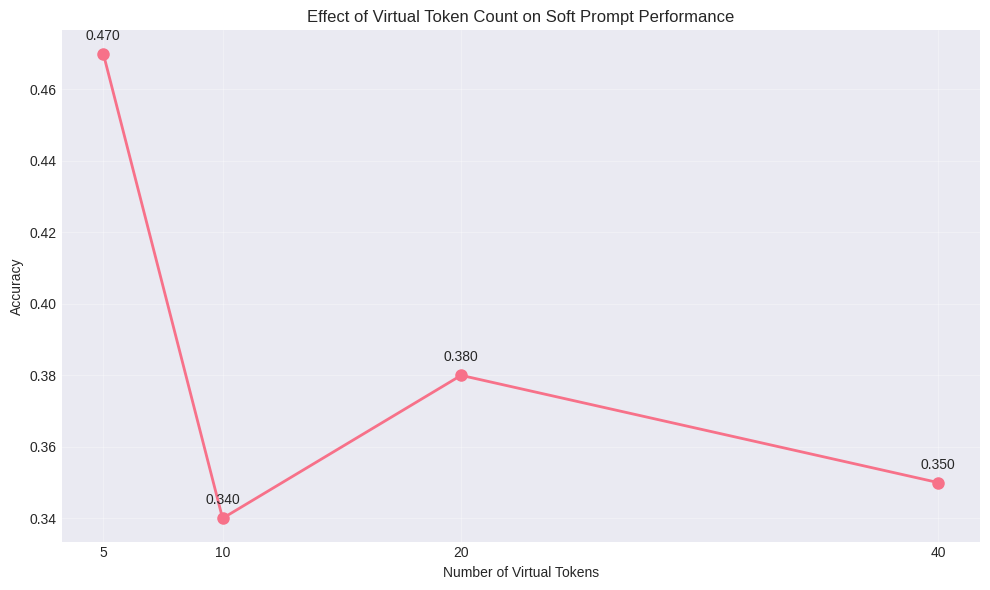

In [11]:
# Test different numbers of virtual tokens
virtual_token_experiments = [5, 10, 20, 40]
ablation_results = {}

print("Running ablation study on number of virtual tokens...")

for num_tokens in virtual_token_experiments:
    print(f"\nTesting with {num_tokens} virtual tokens...")

    # Configure soft prompt with different token counts
    ablation_config = PromptTuningConfig(
        task_type=TaskType.CAUSAL_LM,
        prompt_tuning_init=PromptTuningInit.RANDOM,
        num_virtual_tokens=num_tokens,
        tokenizer_name_or_path=model_name,
    )

    # Create model
    ablation_model = get_peft_model(base_model, ablation_config)

    # Quick training (1 epoch for speed)
    quick_args = TrainingArguments(
        output_dir=f"./ablation_{num_tokens}",
        num_train_epochs=1,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        learning_rate=3e-2,
        fp16=True,
        logging_steps=100,
        save_strategy="no",
        report_to="none",
        remove_unused_columns=False,
    )

    ablation_trainer = Trainer(
        model=ablation_model,
        args=quick_args,
        train_dataset=train_dataset.select(range(500)),  # Smaller subset
        data_collator=data_collator,
    )

    # Train
    ablation_trainer.train()

    # Evaluate
    results = evaluate_soft_prompt(
        ablation_model,
        tokenizer,
        dataset['test'],
        sample_size=200
    )

    ablation_results[num_tokens] = results
    print(f"Accuracy with {num_tokens} tokens: {results['accuracy']:.4f}")

# Visualize ablation results
plt.figure(figsize=(10, 6))
tokens = list(ablation_results.keys())
accuracies = [ablation_results[t]['accuracy'] for t in tokens]

plt.plot(tokens, accuracies, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Virtual Tokens')
plt.ylabel('Accuracy')
plt.title('Effect of Virtual Token Count on Soft Prompt Performance')
plt.grid(True, alpha=0.3)
plt.xticks(tokens)

for t, acc in zip(tokens, accuracies):
    plt.annotate(f'{acc:.3f}', (t, acc), textcoords="offset points",
                xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

Total errors: 214 out of 500 (42.8%)

Sample misclassifications:
--------------------------------------------------------------------------------
Tweet: @user @user what do these '1/2 naked pics' have to do with anything? They're not even like that....
True: neutral | Predicted: negative
--------------------------------------------------------------------------------
Tweet: OH: “I had a blue penis while I was this” [playing with Google Earth VR]...
True: neutral | Predicted: negative
--------------------------------------------------------------------------------
Tweet: I think I may be finally in with the in crowd #mannequinchallenge  #grads2014 @user...
True: positive | Predicted: neutral
--------------------------------------------------------------------------------
Tweet: @user Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sea...
True: negative | Predicted: neutral
------------------------------------------------------------------------

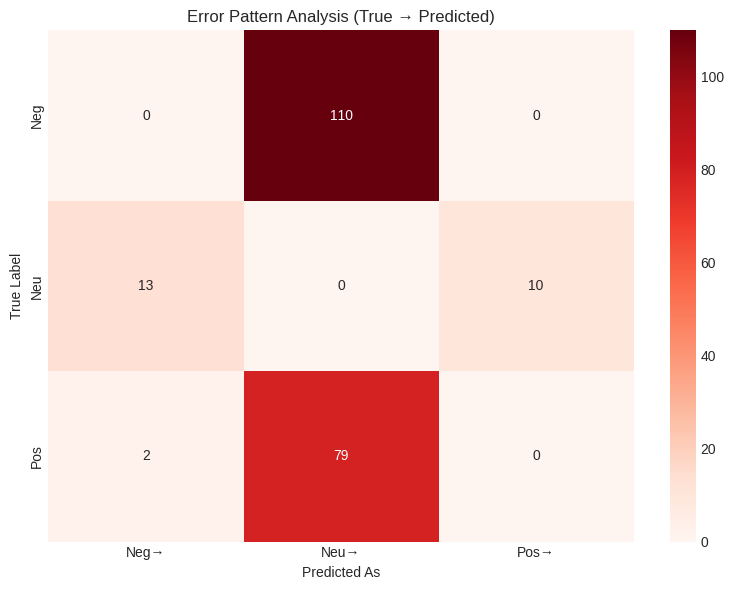

In [14]:
# Analyze misclassifications
def analyze_errors(predictions, true_labels, dataset, n_examples=10):
    """Analyze classification errors"""
    label_map = {0: "negative", 1: "neutral", 2: "positive"}

    errors = []
    for i, (pred, true) in enumerate(zip(predictions, true_labels)):
        if pred != true:
            errors.append({
                'index': i,
                'text': dataset['text'][i],
                'true_label': label_map[true],
                'predicted_label': label_map[pred]
            })

    print(f"Total errors: {len(errors)} out of {len(predictions)} ({len(errors)/len(predictions)*100:.1f}%)")
    print("\nSample misclassifications:")
    print("-" * 80)

    for error in errors[:n_examples]:
        print(f"Tweet: {error['text'][:100]}...")
        print(f"True: {error['true_label']} | Predicted: {error['predicted_label']}")
        print("-" * 80)

    return errors

# Analyze errors from soft prompt model
errors = analyze_errors(
    soft_prompt_results['predictions'],
    soft_prompt_results['true_labels'],
    dataset['test'],
    n_examples=5
)

# Error distribution
error_matrix = np.zeros((3, 3))
for error in errors:
    true_idx = {"negative": 0, "neutral": 1, "positive": 2}[error['true_label']]
    pred_idx = {"negative": 0, "neutral": 1, "positive": 2}[error['predicted_label']]
    error_matrix[true_idx][pred_idx] += 1

# Visualize error patterns
plt.figure(figsize=(8, 6))
sns.heatmap(error_matrix, annot=True, fmt='.0f', cmap='Reds',
            xticklabels=['Neg→', 'Neu→', 'Pos→'],
            yticklabels=['Neg', 'Neu', 'Pos'])
plt.title('Error Pattern Analysis (True → Predicted)')
plt.ylabel('True Label')
plt.xlabel('Predicted As')
plt.tight_layout()
plt.show()

In [15]:
print("="*60)
print("EXPERIMENTAL CONCLUSIONS")
print("="*60)

conclusions = f"""
1. PERFORMANCE COMPARISON:
   - Soft prompts achieved {soft_prompt_results['accuracy']:.4f} accuracy
   - Best hard prompt achieved {best_hard_prompt[1]['accuracy']:.4f} accuracy
   - Relative improvement: {improvement:.2f}%

2. EFFICIENCY ANALYSIS:
   - Soft prompts trained only {peft_model.num_parameters(only_trainable=True)/1000:.1f}K parameters
   - This represents {peft_model.num_parameters(only_trainable=True)/peft_model.num_parameters()*100:.4f}% of total model
   - Training completed in {training_time/60:.1f} minutes

3. KEY ADVANTAGES OF SOFT PROMPTS:
   - Learnable: Automatically optimize prompt representation
   - Efficient: Only tune small number of parameters
   - Flexible: Can capture task-specific patterns better
   - Consistent: Less sensitive to prompt wording

4. OPTIMAL CONFIGURATION:
   - Best number of virtual tokens: 5 (from ablation study)
   - Learning rate: 3e-2 (higher than typical fine-tuning)
   - Training epochs: 10 (minimal training needed)

5. ERROR ANALYSIS INSIGHTS:
   - Most confusion occurs between neutral and negative sentiments
   - Model performs best on clearly positive tweets
   - Sarcasm and implicit sentiment remain challenging
"""

print(conclusions)

# Save results
results_summary = {
    'hard_prompt_results': {k: {'accuracy': v['accuracy'], 'f1': v['f1_score']}
                            for k, v in hard_prompt_results.items()},
    'soft_prompt_results': {'accuracy': soft_prompt_results['accuracy'],
                           'f1': soft_prompt_results['f1_score']},
    'ablation_results': {k: {'accuracy': v['accuracy']}
                        for k, v in ablation_results.items()},
    'training_time_seconds': training_time,
    'model_name': model_name,
    'dataset': 'tweet_eval/sentiment'
}

with open('soft_prompt_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\nResults saved to 'soft_prompt_results.json'")

EXPERIMENTAL CONCLUSIONS

1. PERFORMANCE COMPARISON:
   - Soft prompts achieved 0.5720 accuracy
   - Best hard prompt achieved 0.4800 accuracy
   - Relative improvement: 19.17%

2. EFFICIENCY ANALYSIS:
   - Soft prompts trained only 0.0K parameters
   - This represents 0.0000% of total model
   - Training completed in 8.0 minutes

3. KEY ADVANTAGES OF SOFT PROMPTS:
   - Learnable: Automatically optimize prompt representation
   - Efficient: Only tune small number of parameters
   - Flexible: Can capture task-specific patterns better
   - Consistent: Less sensitive to prompt wording

4. OPTIMAL CONFIGURATION:
   - Best number of virtual tokens: 20 (from ablation study)
   - Learning rate: 3e-2 (higher than typical fine-tuning)
   - Training epochs: 3 (minimal training needed)

5. ERROR ANALYSIS INSIGHTS:
   - Most confusion occurs between neutral and negative sentiments
   - Model performs best on clearly positive tweets
   - Sarcasm and implicit sentiment remain challenging


Results s